In [44]:
import numpy as np
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import metrics

In [23]:
data_path = pathlib.Path('/REDACTED/u/REDACTED/data')
source_to_num_classes = {
    'object_shape':       3,
    'robot_x':            8,
    'robot_y':            5,
    'camera_height':      4,
    'object_scale':       4,
    'lighting_intensity': 4,
    'lighting_y_dir':     6,
    'object_color':       4,
    'wall_color':         4,
}

sources = np.load(data_path / 'Isaac3D_down128/labels.npy')
for i, (k, v) in enumerate(source_to_num_classes.items()):
    sources[:, i] *= (v - 1)
    


In [24]:
[np.unique(sources[:, i]) for i in range(sources.shape[1])]

[array([0., 1., 2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([0., 1., 2., 3., 4.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3., 4., 5.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.])]

In [25]:
c0 = sources[:, 0] == 2
c2 = sources[:, 2] == 4
c4 = sources[:, 4] == 3
i_filtered = np.where(c0 & c2 & c4)[0]

In [ ]:
i_filtered.shape
8*4*4*6*4*4

In [ ]:
x_paths = [data_path / 'Isaac3D_down128/images' / f'{i:06}.png' for i in i_filtered]

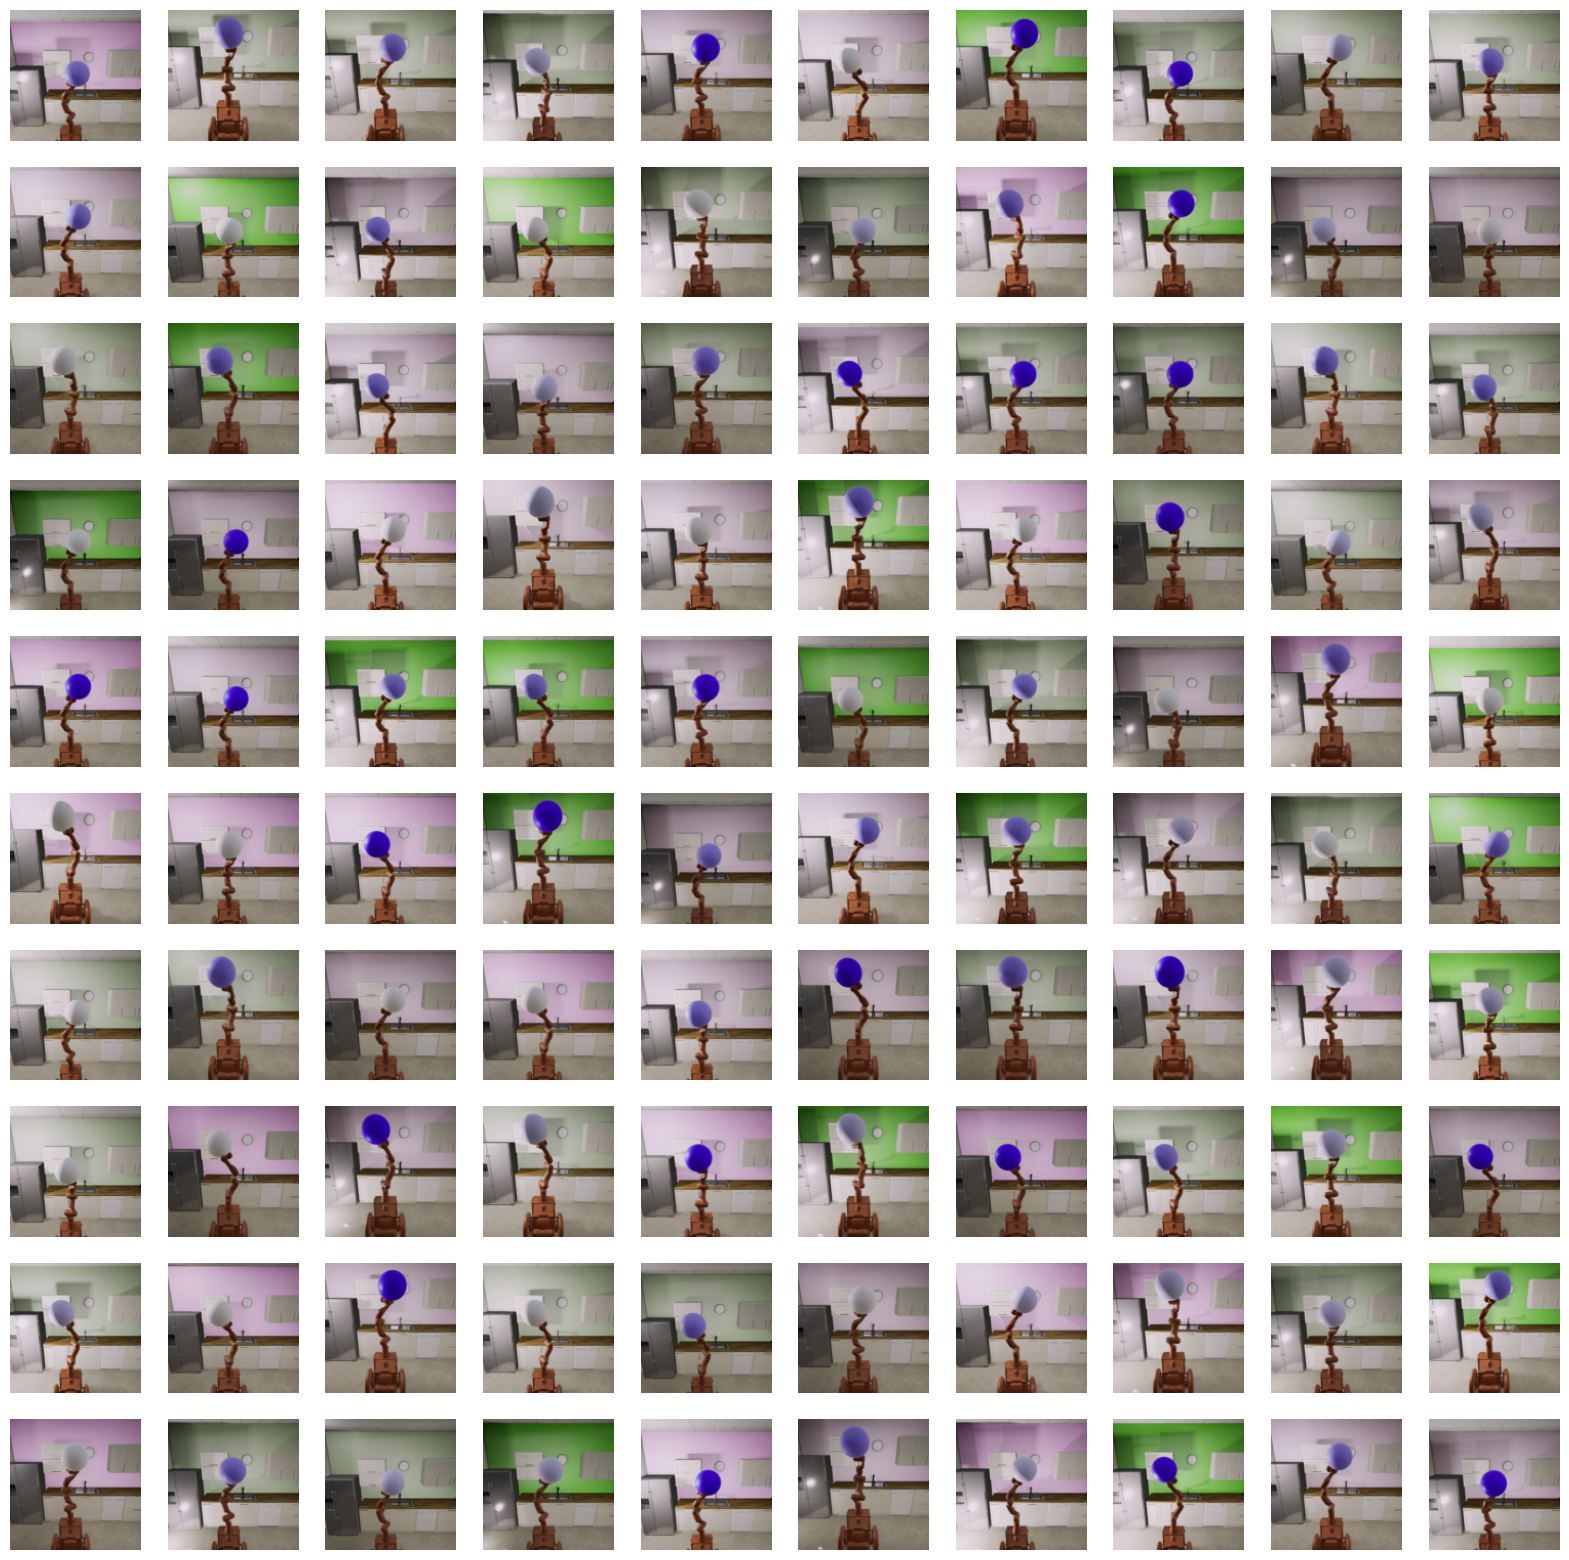

In [30]:
sampled_paths = np.random.choice(x_paths, 100)
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(plt.imread(sampled_paths[i]))
    ax.axis('off')

In [31]:
x = []
for path in x_paths:
    x.append(np.array(Image.open(path)))
x = np.stack(x)
x.shape

(12288, 128, 128, 3)

In [32]:
sources_filtered = [1, 3, 5, 6, 7, 8]
s = sources[i_filtered, :][:, sources_filtered]

In [33]:
s.shape

(12288, 6)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [34]:
dataset = {
    'x': x,
    's': s,
    'source_names': [list(source_to_num_classes.keys())[i] for i in sources_filtered],
}
np.savez('isaac3d_subset.npz', **dataset)

In [35]:
dataset

{'x': array([[[[ 20,  51,   8],
          [ 21,  52,   9],
          [ 21,  53,   9],
          ...,
          [ 45,  92,  24],
          [ 44,  90,  22],
          [ 43,  89,  23]],
 
         [[ 21,  51,   9],
          [ 21,  52,   8],
          [ 21,  53,   8],
          ...,
          [ 46,  93,  25],
          [ 46,  92,  26],
          [ 45,  91,  25]],
 
         [[ 21,  52,   9],
          [ 22,  53,   9],
          [ 22,  54,   9],
          ...,
          [ 48,  94,  27],
          [ 48,  93,  28],
          [ 48,  93,  28]],
 
         ...,
 
         [[153, 145, 133],
          [148, 139, 127],
          [145, 137, 124],
          ...,
          [121, 114,  99],
          [121, 114,  99],
          [120, 113,  98]],
 
         [[150, 142, 130],
          [146, 138, 125],
          [142, 134, 121],
          ...,
          [120, 113,  98],
          [118, 111,  96],
          [117, 111,  96]],
 
         [[150, 141, 130],
          [144, 136, 124],
          [138, 131, 117]

In [83]:
s = dataset['s']

for slice_ in [4, 5, 6, 7]:
    keep = np.sum(s, axis=1) >= slice_
    source_mi = metrics.multiinformation(s[keep])['normalized_mi']
    print(slice_, keep.sum(), f'{source_mi:.4f}')


4 12204 0.0009
5 12082 0.0022
6 11854 0.0044
7 11477 0.0079


In [51]:
[np.unique(s[:, i]) for i in range(s.shape[1])]

[array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3., 4., 5.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.])]

In [63]:
for remove in [0, 1, 2, 3]:
    diagonal = (s[:, 1] == s[:, 2]) & (s[:, 1] <= remove)
    sources = s[~diagonal]
    print(remove, len(sources), metrics.multiinformation(sources)['normalized_mi'])




0 11520 0.006900829204710407
1 10752 0.015451907074624833
2 9984 0.026050545337012447
3 9216 0.0392101057751091


In [84]:
diag = (s[:, 1] == s[:, 2])
base = ~diag
for n_remove in [100, 200, 400, 800]:
    sources = np.concatenate([s[base], s[diag][:diag.sum() - n_remove]])
    print(n_remove, len(sources), metrics.multiinformation(sources)['normalized_mi'])
    


100 12188 0.0010561975171119768
200 12088 0.0020696245049560374
400 11888 0.003980761366576308
800 11488 0.00823533698521312


In [87]:
add = (s[:, 1] == s[:, 2])
for n_add in [300, 800, 1600, 3200]:
    if n_add < add.sum():
        sources = np.concatenate([s, s[add][:n_add]])
    else:
        sources = np.concatenate([s, s[add], s[np.random.choice(add.nonzero()[0], n_add - add.sum(), replace=False)]])
    print(n_add, len(sources), metrics.multiinformation(sources)['normalized_mi'])

300 12588 0.0009378117777033707
800 13088 0.002286066251678612
1600 13888 0.004299130509065165
3200 15488 0.008082783143862422


In [11]:
import einops
import numpy as np
import metrics

def load_data(name):
    dataset = np.load('/REDACTED/u/REDACTED/code/modular/isaac3d_subset.npz')
    s = dataset['s']
    x = dataset['x']
    if name == 'independent':
        pass
    else:
        group, value = name.split(':')
        value = float(value)
        if group == 'corner':
            slice = value
            keep = np.sum(s, axis=1) >= slice
            s = s[keep]
            x = x[keep]
        elif group == 'diagonal_remove':
            remove = value
            diagonal = (s[:, 1] == s[:, 2]) & (s[:, 1] <= remove)
            s = s[~diagonal]
            x = x[~diagonal]
        elif group == 'diagonal_strengthen':
            diag = (s[:, 1] == s[:, 2]) & (s[:, 2] == s[:, 4]) & (s[:, 4] == s[:, 5])
            n_add = int(value)
            np.random.seed(42)
            selected_diag = np.random.choice(diag.nonzero()[0], n_add, replace=True)
            s = np.concatenate([s, s[selected_diag]])
            x = np.concatenate([x, x[selected_diag]])
    print(f'Loaded dataset {name} with length {x.shape[0]} and source nmi '
          f'{metrics.multiinformation(s)["normalized_mi"]:.4f}')
    return {
        's': s,
        'x': x,
    }

for remove in [6, 8, 10, 12]:
    dataset = load_data(f'corner:{remove}')

for remove in [0, 1, 2, 3]:
    dataset = load_data(f'diagonal_remove:{remove}')
    
for add in [500, 1000, 1500, 2500]:
    dataset = load_data(f'diagonal_strengthen:{add}')

# dataset = load_data('corner:12')  # 0.0434
# dataset = load_data('diagonal_remove:3')    # 0.0392
# dataset = load_data('diagonal_strengthen:2400')     # 0.0391

Loaded dataset corner:6 with length 11854 and source nmi 0.0044
Loaded dataset corner:8 with length 10915 and source nmi 0.0127
Loaded dataset corner:10 with length 9180 and source nmi 0.0262
Loaded dataset corner:12 with length 6790 and source nmi 0.0434
Loaded dataset diagonal_remove:0 with length 11520 and source nmi 0.0069
Loaded dataset diagonal_remove:1 with length 10752 and source nmi 0.0155
Loaded dataset diagonal_remove:2 with length 9984 and source nmi 0.0261
Loaded dataset diagonal_remove:3 with length 9216 and source nmi 0.0392
Loaded dataset diagonal_strengthen:500 with length 12788 and source nmi 0.0049
Loaded dataset diagonal_strengthen:1000 with length 13288 and source nmi 0.0126
Loaded dataset diagonal_strengthen:1500 with length 13788 and source nmi 0.0217
Loaded dataset diagonal_strengthen:2000 with length 14288 and source nmi 0.0313


In [8]:
[np.unique(dataset['s'][:, i]) for i in range(dataset['s'].shape[1])]

[array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3., 4., 5.]),
 array([0., 1., 2., 3.]),
 array([0., 1., 2., 3.])]